# Crypto Trading Strategy Monte Carlo Analysis

This notebook performs comprehensive Monte Carlo simulations on crypto trading strategies.

## Key Metrics Calculated:
- **Monte Carlo Simulation**: Multiple backtest runs to assess strategy robustness
- **Sharpe Ratio**: Risk-adjusted return metric (higher is better, >1.0 is good)
- **Expected Value**: Expected profit/loss per trade (positive = profitable strategy)
- **Sortino Ratio**: Downside risk-adjusted return
- **Pass Rate**: Percentage of simulations that pass funded account rules


In [8]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime, timedelta
import pytz
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load crypto data from .Last.txt files (semicolon-separated format)
# Format: Date Time;Open;High;Low;Close;Volume

data_folders = ["BTCUSD DATA", "ETHUSD DATA", "SOLUSD DATA"]
dfs = []

for folder in data_folders:
    if not os.path.exists(folder):
        print(f"Warning: Folder '{folder}' not found, skipping...")
        continue
    
    # Find all .Last.txt files in the folder
    txt_files = glob.glob(os.path.join(folder, "*.Last.txt"))
    
    for f in txt_files:
        try:
            # Read semicolon-separated file with no header
            df = pd.read_csv(f, sep=';', header=None, 
                           names=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume'])
            
            # Parse datetime from format: YYYYMMDD HHMMSS
            df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d %H%M%S')
            
            # Set datetime as index and sort
            df = df.set_index('DateTime').sort_index()
            
            # Add ticker name from folder
            ticker = folder.replace(' DATA', '').replace('USD', '')
            df['Ticker'] = ticker
            
            dfs.append(df)
            print(f"Loaded {len(df)} rows from {os.path.basename(f)}")
            
        except Exception as e:
            print(f"Error loading {f}: {e}")

# Concatenate all DataFrames if any were loaded
if len(dfs) > 0:
    price = pd.concat(dfs, ignore_index=False)
    print(f"\nTotal rows loaded: {len(price)}")
    print(f"Date range: {price.index.min()} to {price.index.max()}")
    print(f"\nFirst few rows:")
    print(price.head())
else:
    print("No data files found! Please check the data folders.")
    price = pd.DataFrame()  # Create empty DataFrame to avoid errors



Libraries imported successfully!
Loaded 525600 rows from BTCUSDT_2019_minute.Last.txt
Loaded 527040 rows from BTCUSDT_2020_minute.Last.txt
Loaded 525600 rows from BTCUSDT_2021_minute.Last.txt
Loaded 525600 rows from BTCUSDT_2022_minute.Last.txt
Loaded 525600 rows from BTCUSDT_2023_minute.Last.txt
Loaded 527040 rows from BTCUSDT_2024_minute.Last.txt
Loaded 499680 rows from BTCUSDT_2025_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2019_minute.Last.txt
Loaded 527040 rows from ETHUSDT_2020_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2021_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2022_minute.Last.txt
Loaded 525600 rows from ETHUSDT_2023_minute.Last.txt
Loaded 527040 rows from ETHUSDT_2024_minute.Last.txt
Loaded 499680 rows from ETHUSDT_2025_minute.Last.txt
Loaded 525600 rows from SOLUSDT_2023_minute.Last.txt
Loaded 527040 rows from SOLUSDT_2024_minute.Last.txt
Loaded 499680 rows from SOLUSDT_2025_minute.Last.txt

Total rows loaded: 8864640
Date range: 2019-01-01 00:00:00 to 202

## 2. Backtesting Engine

This class handles backtesting with account rules and risk metrics.


In [9]:
class CryptoBacktester:
    """
    Backtesting engine for crypto trading strategies with funded account rules.
    """
    
    def __init__(self, account_size=5000, daily_dd_limit=0.02, max_dd_limit=0.03,
                 entry_size=4800, target_gain=500):
        self.account_size = account_size
        self.daily_dd_limit = daily_dd_limit
        self.max_dd_limit = max_dd_limit
        self.entry_size = entry_size
        self.target_gain = target_gain
        
    def run_backtest(self, trades_df, strategy_func=None):
        """
        Run backtest on trades DataFrame.
        
        Parameters:
        -----------
        trades_df : pd.DataFrame
            DataFrame with columns: entry_price, exit_price, entry_time, symbol
        strategy_func : function, optional
            Custom strategy function that returns ('BUY', confidence) or ('HOLD', confidence)
            
        Returns:
        --------
        dict : Backtest results with metrics
        """
        equity_curve = [self.account_size]
        trade_log = []
        current_equity = self.account_size
        peak_equity = self.account_size
        daily_peak = self.account_size
        current_date = None
        
        for _, trade in trades_df.iterrows():
            # Apply strategy if provided
            if strategy_func:
                try:
                    signal, confidence = strategy_func(trade, {'equity': current_equity})
                    if signal != 'BUY':
                        continue
                except:
                    continue
            
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']
            
            # Calculate PnL
            pnl = self.entry_size * ((exit_price - entry_price) / entry_price)
            new_equity = current_equity + pnl
            
            # Check daily DD
            if daily_peak > 0:
                daily_dd = (daily_peak - new_equity) / daily_peak
                if daily_dd > self.daily_dd_limit:
                    break
            
            # Check max DD
            if peak_equity > 0:
                max_dd = (peak_equity - new_equity) / peak_equity
                if max_dd > self.max_dd_limit:
                    break
            
            current_equity = new_equity
            if current_equity > peak_equity:
                peak_equity = current_equity
            if current_equity > daily_peak:
                daily_peak = current_equity
            
            trade_log.append({
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'equity': current_equity
            })
            
            equity_curve.append(current_equity)
            
            # Check target gain
            if current_equity - self.account_size >= self.target_gain:
                break
        
        # Calculate metrics
        equity_array = np.array(equity_curve)
        total_pnl = current_equity - self.account_size
        return_pct = (total_pnl / self.account_size) * 100
        
        # Drawdown calculation
        rolling_max = np.maximum.accumulate(equity_array)
        drawdowns = (rolling_max - equity_array) / rolling_max
        max_dd = drawdowns.max() * 100 if len(drawdowns) > 0 else 0
        
        # Returns for Sharpe/Sortino
        returns = np.diff(equity_array) / equity_array[:-1]
        returns = returns[~np.isnan(returns)]
        
        # Sharpe Ratio (annualized, assuming 312 trading days)
        if len(returns) > 1 and returns.std() > 0:
            sharpe = (returns.mean() * np.sqrt(312)) / returns.std()
        else:
            sharpe = 0
        
        # Sortino Ratio (only downside volatility)
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 1 and downside_returns.std() > 0:
            sortino = (returns.mean() * np.sqrt(312)) / downside_returns.std()
        else:
            sortino = 0
        
        # Expected Value (average PnL per trade)
        if len(trade_log) > 0:
            expected_value = np.mean([t['pnl'] for t in trade_log])
        else:
            expected_value = 0
        
        return {
            'final_equity': current_equity,
            'total_pnl': total_pnl,
            'return_pct': return_pct,
            'num_trades': len(trade_log),
            'max_dd_pct': max_dd,
            'sharpe': sharpe,
            'sortino': sortino,
            'expected_value': expected_value,
            'equity_curve': equity_curve,
            'trade_log': trade_log,
            'passed': total_pnl >= self.target_gain and max_dd < self.max_dd_limit * 100
        }

print("Backtesting engine defined!")


Backtesting engine defined!


## 3. Prepare Trade Data

Convert price data into trade format for backtesting.


In [10]:
# Prepare trade data from price data
# Filter to trading window (7:30-11:00 AM Chicago time)
CHICAGO_TZ = pytz.timezone('America/Chicago')

def prepare_trades_from_data(price_df, symbol='BTC', sample_interval=5, max_trades=1000):
    """
    Convert price data to trade format.
    """
    # Filter to trading hours
    price_df['chicago_time'] = price_df.index.tz_localize('UTC').tz_convert(CHICAGO_TZ)
    price_df['hour'] = price_df['chicago_time'].dt.hour
    price_df['minute'] = price_df['chicago_time'].dt.minute
    
    # Filter to 7:30-11:00 AM Chicago time
    mask = ((price_df['hour'] == 7) & (price_df['minute'] >= 30)) | \
           ((price_df['hour'] >= 8) & (price_df['hour'] < 11))
    
    window_data = price_df[mask].copy()
    
    if len(window_data) == 0:
        return pd.DataFrame()
    
    # Sample every Nth bar
    window_data = window_data.iloc[::sample_interval].head(max_trades)
    
    # Create trades DataFrame
    trades = []
    for i in range(1, len(window_data)):
        current = window_data.iloc[i]
        previous = window_data.iloc[i-1]
        
        trades.append({
            'symbol': symbol,
            'entry_price': previous['Close'],
            'exit_price': current['Close'],
            'entry_time': previous.name,
            'high': current['High'],
            'low': current['Low'],
            'volume': current['Volume'],
            'price_range': current['High'] - current['Low'],
            'cvd': 0,  # Simplified
            'cvd_ma': 0,
            'recent_high': window_data['High'].iloc[max(0, i-20):i].max(),
            'recent_low': window_data['Low'].iloc[max(0, i-20):i].min(),
        })
    
    return pd.DataFrame(trades)

# Prepare trades for BTC
if len(price) > 0 and 'Ticker' in price.columns:
    btc_data = price[price['Ticker'] == 'BTC'].copy()
    trades_df = prepare_trades_from_data(btc_data, symbol='BTC', sample_interval=5, max_trades=500)
    print(f"Prepared {len(trades_df)} trades from BTC data")
    print(f"Date range: {trades_df['entry_time'].min()} to {trades_df['entry_time'].max()}")
else:
    print("No price data available. Please load data first.")
    trades_df = pd.DataFrame()


Prepared 499 trades from BTC data
Date range: 2019-01-01 13:30:00 to 2019-01-12 16:30:00


## 4. Define Trading Strategy

Define your custom trading strategy here. The function should return ('BUY', confidence) or ('HOLD', confidence).


In [11]:
# Example Strategy: Simple momentum-based strategy
def my_strategy(row, context=None):
    """
    Custom trading strategy.
    
    Parameters:
    -----------
    row : pd.Series
        Trade data with entry_price, exit_price, recent_high, recent_low, etc.
    context : dict, optional
        Additional context like current equity
        
    Returns:
    --------
    tuple: (signal, confidence)
        signal: 'BUY' or 'HOLD'
        confidence: float between 0 and 1
    """
    entry_price = row['entry_price']
    recent_high = row.get('recent_high', entry_price * 1.02)
    recent_low = row.get('recent_low', entry_price * 0.98)
    
    # Simple momentum: Buy when price is near recent high
    if entry_price >= recent_high * 0.99:
        return 'BUY', 0.8
    elif entry_price >= recent_low + (recent_high - recent_low) * 0.7:
        return 'BUY', 0.6
    else:
        return 'HOLD', 0.5

print("Strategy defined! Modify 'my_strategy' function to implement your own strategy.")


Strategy defined! Modify 'my_strategy' function to implement your own strategy.


## 5. Monte Carlo Simulation

Run multiple backtests with random sampling to assess strategy robustness.


In [12]:
# Monte Carlo Simulation Parameters
NUM_SIMULATIONS = 500
SAMPLE_SIZE = 100  # Number of trades per simulation

# Initialize backtester
backtester = CryptoBacktester(
    account_size=5000,
    daily_dd_limit=0.02,
    max_dd_limit=0.03,
    entry_size=4800,
    target_gain=500
)

# Run Monte Carlo simulation
print(f"Running {NUM_SIMULATIONS} Monte Carlo simulations...")
results = []

if len(trades_df) > 0:
    for i in range(NUM_SIMULATIONS):
        # Randomly sample trades
        sample_trades = trades_df.sample(n=min(SAMPLE_SIZE, len(trades_df)), replace=True)
        sample_trades = sample_trades.sort_values('entry_time').reset_index(drop=True)
        
        # Run backtest with strategy
        result = backtester.run_backtest(sample_trades, strategy_func=my_strategy)
        results.append(result)
        
        if (i + 1) % 50 == 0:
            print(f"Completed {i + 1}/{NUM_SIMULATIONS} simulations...")
    
    print(f"\n✓ Completed {NUM_SIMULATIONS} simulations!")
else:
    print("No trade data available. Please prepare trades first.")


Running 500 Monte Carlo simulations...
Completed 50/500 simulations...
Completed 100/500 simulations...
Completed 150/500 simulations...
Completed 200/500 simulations...
Completed 250/500 simulations...
Completed 300/500 simulations...
Completed 350/500 simulations...
Completed 400/500 simulations...
Completed 450/500 simulations...
Completed 500/500 simulations...

✓ Completed 500 simulations!


# Plot each cryptocurrency in separate charts
if 'Ticker' in price.columns and len(price) > 0:
    tickers = sorted(price['Ticker'].unique())
    num_tickers = len(tickers)
    
    # Create subplots - one for each cryptocurrency
    fig, axes = plt.subplots(num_tickers, 1, figsize=(14, 5 * num_tickers))
    
    # If only one ticker, axes won't be an array
    if num_tickers == 1:
        axes = [axes]
    
    for idx, ticker in enumerate(tickers):
        ticker_data = price[price['Ticker'] == ticker]['Close']
        
        axes[idx].plot(ticker_data.index, ticker_data.values, linewidth=1.5, color=f'C{idx}')
        axes[idx].set_title(f'{ticker} Close Price Over Time', fontsize=14, fontweight='bold', pad=10)
        axes[idx].set_xlabel('Date', fontsize=12)
        axes[idx].set_ylabel('Price (USD)', fontsize=12)
        axes[idx].grid(True, alpha=0.3)
        
        # Format x-axis dates
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add some stats as text
        min_price = ticker_data.min()
        max_price = ticker_data.max()
        current_price = ticker_data.iloc[-1]
        axes[idx].text(0.02, 0.98, f'Min: ${min_price:,.2f} | Max: ${max_price:,.2f} | Current: ${current_price:,.2f}',
                      transform=axes[idx].transAxes, fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot.")

In [ ]:
# Extract metrics from results
if len(results) > 0:
    sharpe_ratios = [r['sharpe'] for r in results]
    sortino_ratios = [r['sortino'] for r in results]
    expected_values = [r['expected_value'] for r in results]
    returns = [r['return_pct'] for r in results]
    max_dds = [r['max_dd_pct'] for r in results]
    pass_rates = [r['passed'] for r in results]
    
    # Calculate statistics
    avg_sharpe = np.mean(sharpe_ratios)
    std_sharpe = np.std(sharpe_ratios)
    median_sharpe = np.median(sharpe_ratios)
    
    avg_sortino = np.mean(sortino_ratios)
    std_sortino = np.std(sortino_ratios)
    
    avg_expected_value = np.mean(expected_values)
    std_expected_value = np.std(expected_values)
    
    pass_rate = np.mean(pass_rates) * 100
    
    # Display results with prominent formatting
    print("=" * 70)
    print(" " * 15 + "MONTE CARLO SIMULATION RESULTS")
    print("=" * 70)
    
    print(f"\n{'='*70}")
    print(f"{'📊 PASS RATE':<30} {pass_rate:>6.1f}% ({sum(pass_rates)}/{len(results)} simulations passed)")
    print(f"{'='*70}\n")
    
    # Sharpe Ratio - Prominent Display
    sharpe_status = "✅ GOOD" if avg_sharpe > 1.0 else "⚠️ MODERATE" if avg_sharpe > 0.5 else "❌ POOR"
    print(f"{'🎯 SHARPE RATIO':<30} {sharpe_status}")
    print(f"{'─'*70}")
    print(f"{'   Average:':<25} {avg_sharpe:>8.3f}  {'(>1.0 is good, >2.0 is excellent)'}")
    print(f"{'   Median:':<25} {median_sharpe:>8.3f}")
    print(f"{'   Std Dev:':<25} {std_sharpe:>8.3f}")
    print(f"{'   Range:':<25} [{np.min(sharpe_ratios):>6.3f}, {np.max(sharpe_ratios):>6.3f}]")
    
    # Expected Value - Prominent Display
    ev_status = "✅ PROFITABLE" if avg_expected_value > 0 else "❌ LOSING"
    print(f"\n{'💰 EXPECTED VALUE (Avg PnL per Trade)':<30} {ev_status}")
    print(f"{'─'*70}")
    print(f"{'   Average:':<25} ${avg_expected_value:>7.2f}  {'(Positive = profitable strategy)'}")
    print(f"{'   Std Dev:':<25} ${std_expected_value:>7.2f}")
    print(f"{'   Range:':<25} [${np.min(expected_values):>6.2f}, ${np.max(expected_values):>6.2f}]")
    
    # Sortino Ratio
    print(f"\n{'📈 SORTINO RATIO':<30}")
    print(f"{'─'*70}")
    print(f"{'   Average:':<25} {avg_sortino:>8.3f}  {'(Downside risk-adjusted return)'}")
    print(f"{'   Std Dev:':<25} {std_sortino:>8.3f}")
    
    # Other Metrics
    print(f"\n{'📉 OTHER METRICS':<30}")
    print(f"{'─'*70}")
    print(f"{'   Avg Return:':<25} {np.mean(returns):>8.2f}%")
    print(f"{'   Avg Max DD:':<25} {np.mean(max_dds):>8.2f}%")
    print(f"{'   Avg Trades:':<25} {np.mean([r['num_trades'] for r in results]):>8.0f}")
    
    print(f"\n{'='*70}")
    
    # Create summary DataFrame for easy viewing
    summary_data = {
        'Metric': ['Sharpe Ratio', 'Sortino Ratio', 'Expected Value ($)', 'Return (%)', 'Max DD (%)', 'Pass Rate (%)'],
        'Mean': [f"{avg_sharpe:.3f}", f"{avg_sortino:.3f}", f"${avg_expected_value:.2f}", 
                 f"{np.mean(returns):.2f}", f"{np.mean(max_dds):.2f}", f"{pass_rate:.1f}"],
        'Std Dev': [f"{std_sharpe:.3f}", f"{std_sortino:.3f}", f"${std_expected_value:.2f}",
                    f"{np.std(returns):.2f}", f"{np.std(max_dds):.2f}", "N/A"],
        'Min': [f"{np.min(sharpe_ratios):.3f}", f"{np.min(sortino_ratios):.3f}", 
                f"${np.min(expected_values):.2f}", f"{np.min(returns):.2f}", f"{np.min(max_dds):.2f}", "N/A"],
        'Max': [f"{np.max(sharpe_ratios):.3f}", f"{np.max(sortino_ratios):.3f}",
                f"${np.max(expected_values):.2f}", f"{np.max(returns):.2f}", f"{np.max(max_dds):.2f}", "N/A"]
    }
    summary_df = pd.DataFrame(summary_data)
    
    print("\n📊 Summary Statistics Table:")
    print(summary_df.to_string(index=False))
    
else:
    print("No results available. Run Monte Carlo simulation first.")


MONTE CARLO SIMULATION RESULTS

📊 Pass Rate: 1.0% (5/500 passed)

🎯 SHARPE RATIO:
   Average: 0.426
   Median:  1.296
   Std Dev: 3.160
   Min:     -20.250
   Max:     6.767

📈 SORTINO RATIO:
   Average: 4.609
   Std Dev: 11.974

💰 EXPECTED VALUE (Avg PnL per Trade):
   Average: $0.76
   Std Dev: $2.95
   Min:     $-22.80
   Max:     $16.88

📉 Other Metrics:
   Avg Return: 1.45%
   Avg Max DD: 1.19%


## 7. Visualizations

Visualize the Monte Carlo results with distributions and key metrics.


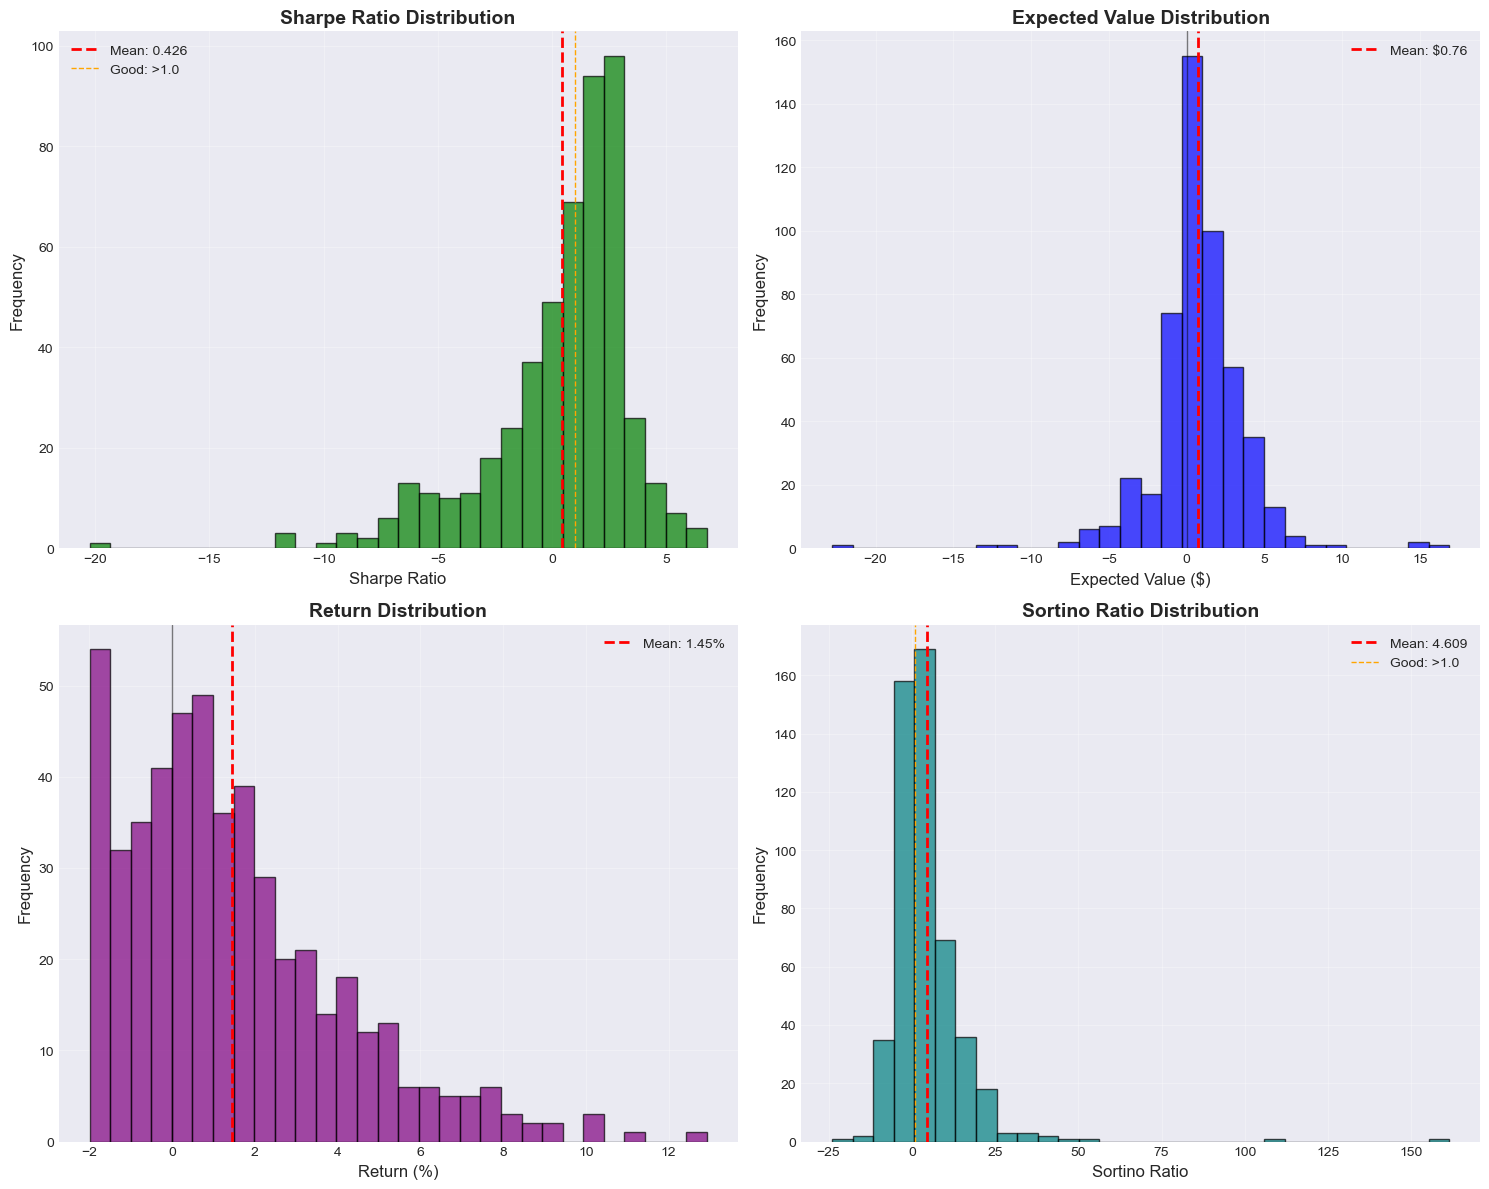


📊 Summary Statistics Table:
            Metric  Mean Std Dev     Min     Max
      Sharpe Ratio 0.426   3.160 -20.250   6.767
     Sortino Ratio 4.609  11.974 -23.946 161.345
Expected Value ($) $0.76   $2.95 $-22.80  $16.88
        Return (%)  1.45    2.62   -2.00   12.92
        Max DD (%)  1.19    0.48    0.26    2.00


In [ ]:
# Create comprehensive visualizations
if len(results) > 0:
    # Create figure with 2x2 layout, emphasizing Sharpe and Expected Value
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Sharpe Ratio Distribution (Top Left - Prominent)
    ax1 = fig.add_subplot(gs[0, 0])
    n, bins, patches = ax1.hist(sharpe_ratios, bins=30, alpha=0.7, color='green', edgecolor='black', linewidth=1.2)
    ax1.axvline(avg_sharpe, color='red', linestyle='--', linewidth=3, label=f'Mean: {avg_sharpe:.3f}')
    ax1.axvline(1.0, color='orange', linestyle='--', linewidth=2, label='Good Threshold: >1.0')
    ax1.axvline(2.0, color='gold', linestyle=':', linewidth=2, label='Excellent: >2.0')
    ax1.set_xlabel('Sharpe Ratio', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=13)
    ax1.set_title('🎯 Sharpe Ratio Distribution\n(Risk-Adjusted Returns)', fontsize=15, fontweight='bold', pad=10)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    # Color bars based on value
    for i, (patch, bin_val) in enumerate(zip(patches, bins[:-1])):
        if bin_val >= 1.0:
            patch.set_facecolor('darkgreen')
        elif bin_val >= 0.5:
            patch.set_facecolor('lightgreen')
        else:
            patch.set_facecolor('lightcoral')
    
    # 2. Expected Value Distribution (Top Right - Prominent)
    ax2 = fig.add_subplot(gs[0, 1])
    n2, bins2, patches2 = ax2.hist(expected_values, bins=30, alpha=0.7, color='blue', edgecolor='black', linewidth=1.2)
    ax2.axvline(avg_expected_value, color='red', linestyle='--', linewidth=3, label=f'Mean: ${avg_expected_value:.2f}')
    ax2.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.7, label='Break-even')
    ax2.set_xlabel('Expected Value ($)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=13)
    ax2.set_title('💰 Expected Value Distribution\n(Average PnL per Trade)', fontsize=15, fontweight='bold', pad=10)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    # Color bars: green for positive, red for negative
    for i, (patch, bin_val) in enumerate(zip(patches2, bins2[:-1])):
        if bin_val >= 0:
            patch.set_facecolor('steelblue')
        else:
            patch.set_facecolor('lightcoral')
    
    # 3. Sortino Ratio Distribution (Middle Left)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(sortino_ratios, bins=30, alpha=0.7, color='teal', edgecolor='black')
    ax3.axvline(avg_sortino, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_sortino:.3f}')
    ax3.axvline(1.0, color='orange', linestyle='--', linewidth=1, label='Good: >1.0')
    ax3.set_xlabel('Sortino Ratio', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('📈 Sortino Ratio Distribution\n(Downside Risk-Adjusted)', fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Return Distribution (Middle Right)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist(returns, bins=30, alpha=0.7, color='purple', edgecolor='black')
    ax4.axvline(np.mean(returns), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(returns):.2f}%')
    ax4.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax4.set_xlabel('Return (%)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('📉 Return Distribution', fontsize=13, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Key Metrics Comparison (Bottom - Span both columns)
    ax5 = fig.add_subplot(gs[2, :])
    metrics = ['Sharpe\nRatio', 'Expected\nValue ($)', 'Sortino\nRatio', 'Return\n(%)', 'Max DD\n(%)']
    values = [avg_sharpe, avg_expected_value/10, avg_sortino, np.mean(returns), np.mean(max_dds)]  # Scale EV for visibility
    colors = ['green' if v > 0 else 'red' for v in [avg_sharpe, avg_expected_value, avg_sortino, np.mean(returns), -np.mean(max_dds)]]
    bars = ax5.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax5.axhline(0, color='black', linestyle='-', linewidth=1)
    ax5.set_ylabel('Normalized Value', fontsize=12)
    ax5.set_title('📊 Key Metrics Comparison', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    # Add value labels on bars
    for i, (bar, val, orig_val) in enumerate(zip(bars, values, [avg_sharpe, avg_expected_value, avg_sortino, np.mean(returns), np.mean(max_dds)])):
        height = bar.get_height()
        label = f'{orig_val:.2f}' if i != 1 else f'${orig_val:.2f}'
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')
    
    plt.suptitle('Monte Carlo Simulation Results - Key Metrics Visualization', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.show()
    
else:
    print("No results to visualize. Run Monte Carlo simulation first.")


## 8. Summary & Interpretation

### 🎯 Key Metrics Explained:

#### **Sharpe Ratio** (Risk-Adjusted Returns)
- **Formula**: (Average Return - Risk-Free Rate) / Standard Deviation of Returns
- **Interpretation**: 
  - **> 2.0**: Excellent strategy
  - **1.0 - 2.0**: Good strategy
  - **0.5 - 1.0**: Moderate strategy
  - **< 0.5**: Poor strategy
- **What it tells you**: How much excess return you get per unit of risk

#### **Expected Value** (Average PnL per Trade)
- **Formula**: Average of all trade PnLs
- **Interpretation**:
  - **Positive**: Strategy is profitable on average
  - **Negative**: Strategy loses money on average
- **What it tells you**: Whether your strategy makes money over many trades

#### **Sortino Ratio** (Downside Risk-Adjusted Returns)
- **Similar to Sharpe but only considers downside volatility**
- **Better for strategies with asymmetric return distributions**
- **> 1.0**: Good downside protection

### 📊 Strategy Assessment Checklist:

Based on the Monte Carlo results, evaluate:

1. **✅ Profitability**: 
   - Expected Value > $0 = Profitable strategy
   - Higher Expected Value = More profitable per trade

2. **✅ Risk-Adjusted Performance**:
   - Sharpe Ratio > 1.0 = Good risk-adjusted returns
   - Higher Sharpe = Better risk-adjusted performance

3. **✅ Consistency**:
   - Low standard deviation in Sharpe/Expected Value = More consistent
   - High standard deviation = Unpredictable results

4. **✅ Risk Management**:
   - Lower Max DD = Better risk control
   - Pass Rate > 60% = Reliable strategy

5. **✅ Reliability**:
   - Higher Pass Rate = More likely to succeed in live trading
   - Consistent positive Expected Value = Sustainable strategy


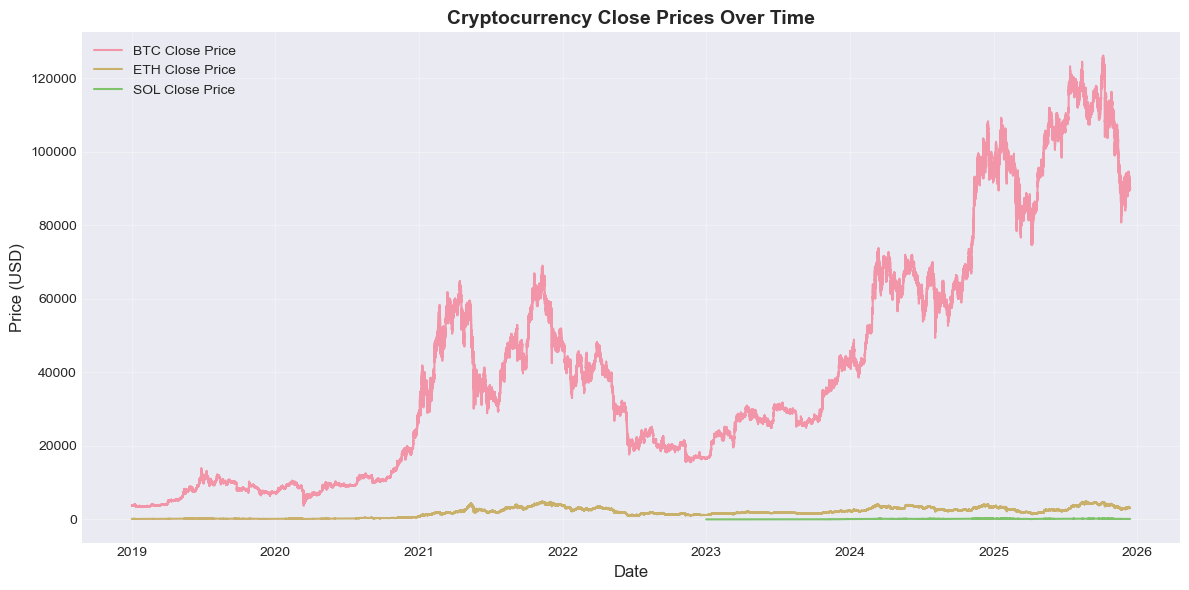

In [15]:
# Plot Close prices with proper labels
plt.figure(figsize=(12, 6))

# Check if we have multiple tickers
if 'Ticker' in price.columns:
    tickers = price['Ticker'].unique()
    if len(tickers) > 1:
        # Plot each ticker separately with labels
        for ticker in tickers:
            ticker_data = price[price['Ticker'] == ticker]['Close']
            plt.plot(ticker_data.index, ticker_data.values, label=f'{ticker} Close Price', alpha=0.7)
        plt.legend()
        plt.title('Cryptocurrency Close Prices Over Time', fontsize=14, fontweight='bold')
    else:
        # Single ticker
        plt.plot(price['Close'], label=f'{tickers[0]} Close Price')
        plt.legend()
        plt.title(f'{tickers[0]} Close Price Over Time', fontsize=14, fontweight='bold')
else:
    # No ticker column, just plot all data
    plt.plot(price['Close'], label='Close Price')
    plt.legend()
    plt.title('Close Price Over Time', fontsize=14, fontweight='bold')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()